In [1]:
!git clone https://github.com/VarunSivamani/ERA-V1.git
%cd ERA-V1/Session 10

Cloning into 'ERA-V1'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 242 (delta 87), reused 175 (delta 31), pack-reused 0
Receiving objects: 100% (242/242), 3.69 MiB | 17.67 MiB/s, done.
Resolving deltas: 100% (87/87), done.
/content/ERA-V1/Session 10


In [2]:
! pip install torch_lr_finder

# Importing libraries

In [3]:
import torch
import torch.optim as optim
from torchsummary import summary
import torch.nn as nn
from torch_lr_finder import LRFinder

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Loading Dataset

In [4]:
from dataset import CIFAR10

data = CIFAR10()

100%|██████████| 170498071/170498071 [00:01<00:00, 100185478.72it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Data Transformations

In [5]:
train_loader , test_loader = data.get_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from utils import get_device, visualize_data

In [7]:
device = get_device()
torch.manual_seed(1)

Device :  cuda


In [8]:
classes = [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ]

# Visualizing the data

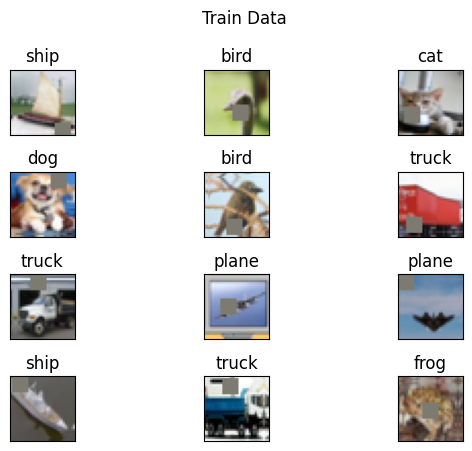

In [9]:
visualize_data(train_loader, 12, "Train Data", classes)

# The Model

In [10]:
from custom_resnet import Model

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [11]:
model = Model(dropout=0.05).to(device)

# Model summary

In [12]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
         ConvLayer-5           [-1, 64, 32, 32]               0
      Custom_Layer-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,728
         MaxPool2d-8          [-1, 128, 16, 16]               0
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
          Dropout-11          [-1, 128, 16, 16]               0
        ConvLayer-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

# Finding the Optimal LR

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-02


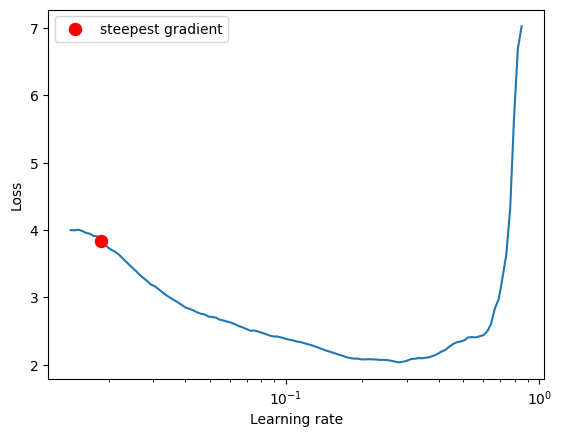

In [14]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
_, best_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# Training and Testing our Model

In [15]:
from backprop import *
from torch.optim.lr_scheduler import OneCycleLR

In [16]:
EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr = best_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')
    train_losses, train_acc = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)

Epoch 1


Train: Loss=1.0395 Batch_id=97 Accuracy=50.14: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]


Test set: Average loss: 0.0023, Accuracy: 5905/10000 (59.05%)

Epoch 2


Train: Loss=0.9464 Batch_id=97 Accuracy=66.77: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.0020, Accuracy: 6681/10000 (66.81%)

Epoch 3


Train: Loss=0.7578 Batch_id=97 Accuracy=72.83: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]


Test set: Average loss: 0.0016, Accuracy: 7176/10000 (71.76%)

Epoch 4


Train: Loss=0.5996 Batch_id=97 Accuracy=75.39: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]


Test set: Average loss: 0.0019, Accuracy: 7073/10000 (70.73%)

Epoch 5


Train: Loss=0.6691 Batch_id=97 Accuracy=77.98: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.0016, Accuracy: 7378/10000 (73.78%)

Epoch 6


Train: Loss=0.5478 Batch_id=97 Accuracy=80.29: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.0015, Accuracy: 7530/10000 (75.30%)

Epoch 7


Train: Loss=0.4722 Batch_id=97 Accuracy=82.25: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.0012, Accuracy: 8007/10000 (80.07%)

Epoch 8


Train: Loss=0.5154 Batch_id=97 Accuracy=83.46: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]


Test set: Average loss: 0.0010, Accuracy: 8302/10000 (83.02%)

Epoch 9


Train: Loss=0.4450 Batch_id=97 Accuracy=84.31: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0010, Accuracy: 8262/10000 (82.62%)

Epoch 10


Train: Loss=0.4674 Batch_id=97 Accuracy=84.69: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]


Test set: Average loss: 0.0012, Accuracy: 8008/10000 (80.08%)

Epoch 11


Train: Loss=0.4314 Batch_id=97 Accuracy=85.16: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]


Test set: Average loss: 0.0009, Accuracy: 8557/10000 (85.57%)

Epoch 12


Train: Loss=0.3759 Batch_id=97 Accuracy=86.14: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]


Test set: Average loss: 0.0011, Accuracy: 8189/10000 (81.89%)

Epoch 13


Train: Loss=0.5019 Batch_id=97 Accuracy=86.31: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]


Test set: Average loss: 0.0008, Accuracy: 8615/10000 (86.15%)

Epoch 14


Train: Loss=0.3556 Batch_id=97 Accuracy=86.87: 100%|██████████| 98/98 [00:30<00:00,  3.25it/s]


Test set: Average loss: 0.0008, Accuracy: 8624/10000 (86.24%)

Epoch 15


Train: Loss=0.3481 Batch_id=97 Accuracy=87.27: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]


Test set: Average loss: 0.0008, Accuracy: 8648/10000 (86.48%)

Epoch 16


Train: Loss=0.3878 Batch_id=97 Accuracy=87.86: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0008, Accuracy: 8622/10000 (86.22%)

Epoch 17


Train: Loss=0.3198 Batch_id=97 Accuracy=88.64: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]


Test set: Average loss: 0.0008, Accuracy: 8657/10000 (86.57%)

Epoch 18


Train: Loss=0.3127 Batch_id=97 Accuracy=89.39: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]


Test set: Average loss: 0.0008, Accuracy: 8792/10000 (87.92%)

Epoch 19


Train: Loss=0.2589 Batch_id=97 Accuracy=90.27: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]


Test set: Average loss: 0.0007, Accuracy: 8830/10000 (88.30%)

Epoch 20


Train: Loss=0.2757 Batch_id=97 Accuracy=91.14: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0006, Accuracy: 8964/10000 (89.64%)

Epoch 21


Train: Loss=0.2604 Batch_id=97 Accuracy=92.34: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0005, Accuracy: 9091/10000 (90.91%)

Epoch 22


Train: Loss=0.2023 Batch_id=97 Accuracy=93.44: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0005, Accuracy: 9112/10000 (91.12%)

Epoch 23


Train: Loss=0.1469 Batch_id=97 Accuracy=94.83: 100%|██████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0005, Accuracy: 9225/10000 (92.25%)

Epoch 24


Train: Loss=0.1017 Batch_id=97 Accuracy=95.96: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]


Test set: Average loss: 0.0004, Accuracy: 9263/10000 (92.63%)



# Plotting results

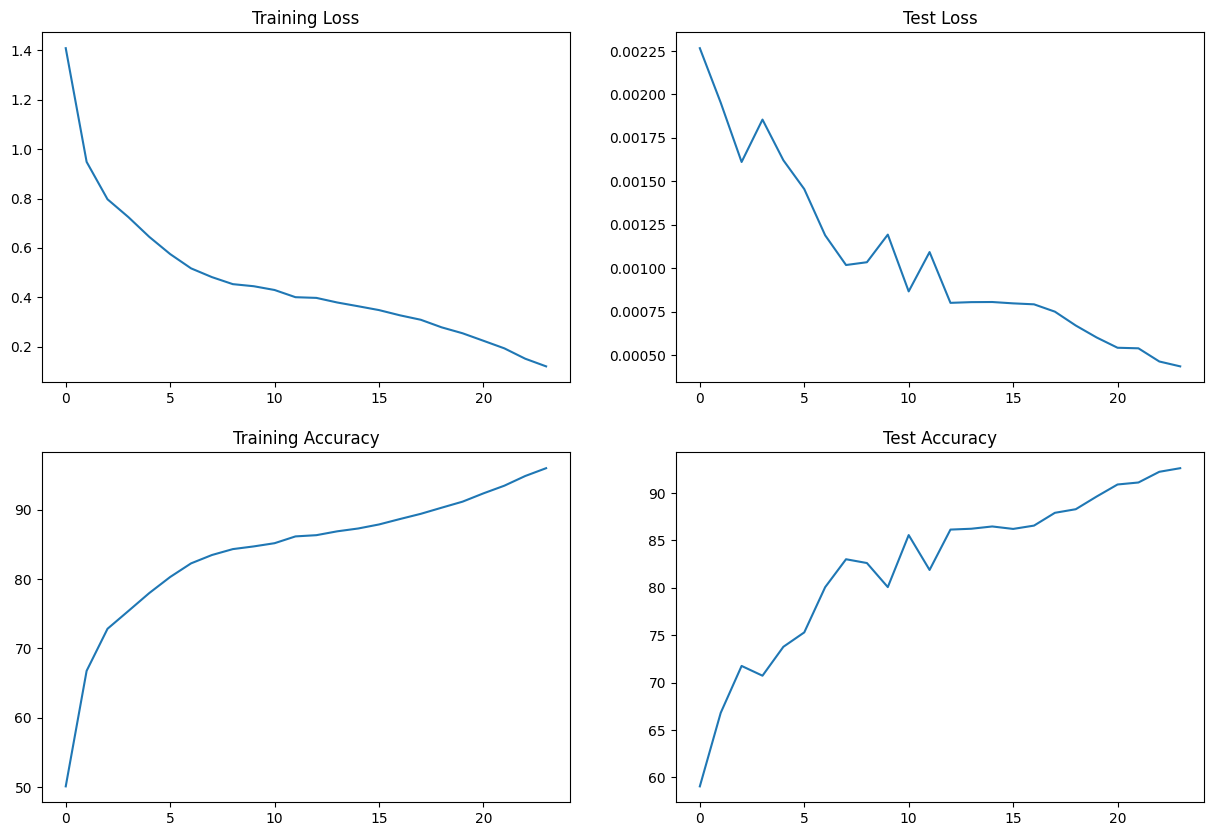

In [17]:
plot_graphs(train_losses, train_acc, test_losses, test_acc)

# Misclassified Images

In [18]:
misclassified_images, predictions, labels = get_misclassified_images(model, test_loader, device)

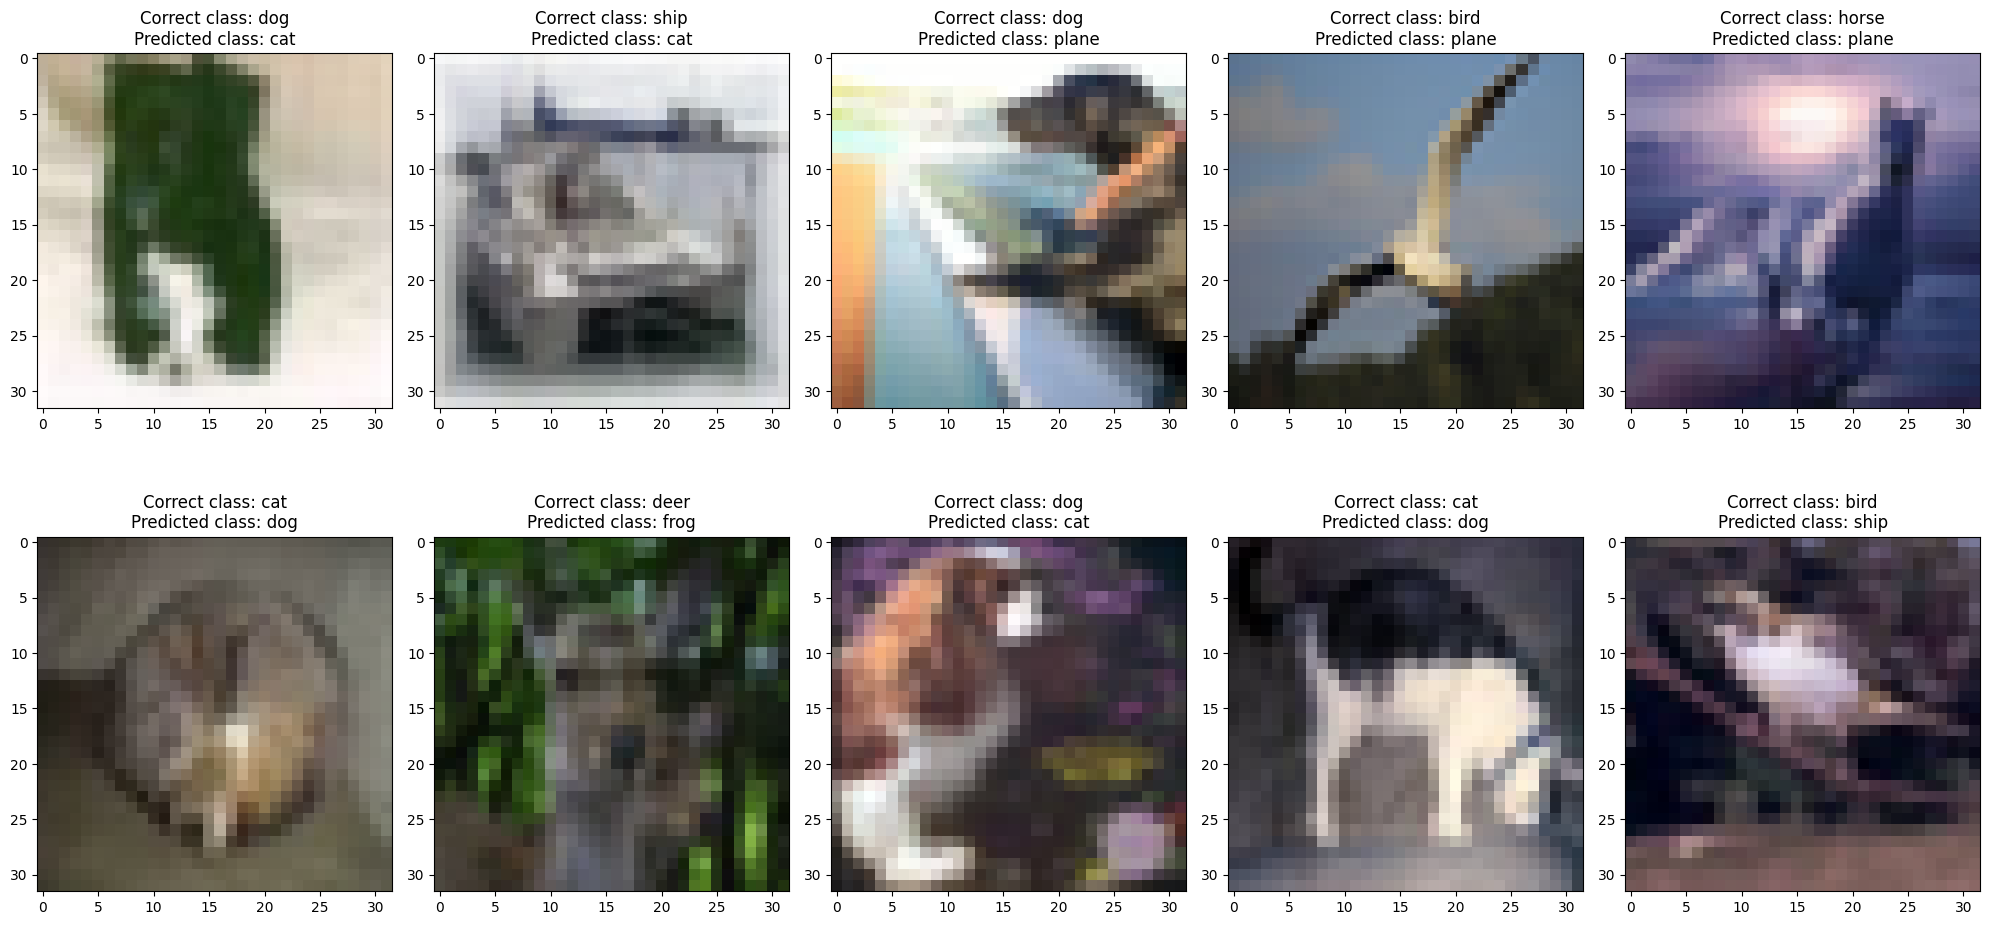

In [19]:
show_misclassified_images(
    misclassified_images[:10],
    predictions[:10],
    labels[:10],
    classes,
)

# Class Accuracy

In [20]:
evaluate_all_class(model, classes, test_loader)

Accuracy for class: plane is 94.0 %
Accuracy for class: car   is 96.7 %
Accuracy for class: bird  is 89.5 %
Accuracy for class: cat   is 83.6 %
Accuracy for class: deer  is 93.5 %
Accuracy for class: dog   is 90.2 %
Accuracy for class: frog  is 94.4 %
Accuracy for class: horse is 94.1 %
Accuracy for class: ship  is 94.7 %
Accuracy for class: truck is 95.6 %
